In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


We start by importing relevant libraries for EDA:

In [2]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

Let's load our data:

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

Let's focus on the training set for now. What kind of information do we have on the passengers ?

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

What we are looking for is a survival prediction for each passenger id of the dataset. 

Before seeing what are the most important features contributing to the outcome, let's first check how curated our dataset is, in terms of:
    1. datatypes 
    2. missing values
    3. Distribution of values

In [6]:
# 1 - Data Types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
# 2 - Missing Values
display(train.isna().sum()) #absolute values
train.isna().sum() / len(train) * 100 #as a proportion of the whole column (%)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Only 0.2 % of the Embarked data is missing, so it should not be too harmful to our prediction. 

However, we may very well expect the age to be an important factor in the outcome (survival rate), so we may have to find a strategy to fill some of the missing values (22%). 

77% of the dataset doesn't give any information on the cabin. This is enormous, so unless there is a very strong correlation between a passenger's cabin and his or her survival, we might discard this feature. Let's keep it for now as we haven't investigated this correlation yet.

In [8]:
# 3 - Values Distribution
train[ list(train.columns) [1:] ].describe() #not taking into account PassengerId

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's examine whether a strong correlation exists between the cabin number (if it exists) and the survival rate. Else, we will simply disregard the cabin number feature in our model due to the high number of missing values. 

First, we isolate the number of the letter for each cabin (it could be related to the floor on which the cabin is located):

In [9]:
from string import ascii_uppercase

train['Floor_Num'] = train['Cabin'].apply(lambda x: str(x)[0] if x != np.nan else np.nan)

for i in range(len(train['Floor_Num'])):
    if train.loc[i,'Floor_Num'] =='n' or train.loc[i,'Floor_Num'] =='T':
        train.loc[i,'Floor_Num'] = 'None'

train['Floor_Num'] = train['Floor_Num'].astype('category')

train['Floor_Num']

0      None
1         C
2      None
3         C
4      None
       ... 
886    None
887       B
888    None
889       C
890    None
Name: Floor_Num, Length: 891, dtype: category
Categories (8, object): [A, B, C, D, E, F, G, None]

In [10]:
train['Floor_Num'].unique()

[None, C, E, G, D, A, B, F]
Categories (8, object): [None, C, E, G, D, A, B, F]

Hence, we have 7 categories of cabin in total (not taking into account the nan values and the standalone T category). Let's visualize the survival rate for each category:

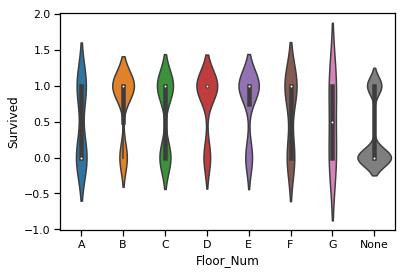

In [11]:
sns.set_context('notebook')

_ = sns.violinplot(data = train, x = 'Floor_Num', y = 'Survived')

There is only one occurrence for category T (the passenger did not survive). It seems that categories B,C,D, E and F had better survival rates than the others. What were their mean survival rates?

In [12]:
print('Mean survival rate for category A : {:.2%}'.format(train[train['Floor_Num'] == 'A']['Survived'].mean()))
print('Mean survival rate for category B : {:.2%}'.format(train[train['Floor_Num'] == 'B']['Survived'].mean()))
print('Mean survival rate for category C : {:.2%}'.format(train[train['Floor_Num'] == 'C']['Survived'].mean()))
print('Mean survival rate for category D : {:.2%}'.format(train[train['Floor_Num'] == 'D']['Survived'].mean()))
print('Mean survival rate for category E : {:.2%}'.format(train[train['Floor_Num'] == 'E']['Survived'].mean()))
print('Mean survival rate for category F : {:.2%}'.format(train[train['Floor_Num'] == 'F']['Survived'].mean()))
print('Mean survival rate for category G : {:.2%}'.format(train[train['Floor_Num'] == 'G']['Survived'].mean()))
print('Mean survival rate for category T : {:.2%}'.format(train[train['Floor_Num'] == 'T']['Survived'].mean()))

Mean survival rate for category A : 46.67%
Mean survival rate for category B : 74.47%
Mean survival rate for category C : 59.32%
Mean survival rate for category D : 75.76%
Mean survival rate for category E : 75.00%
Mean survival rate for category F : 61.54%
Mean survival rate for category G : 50.00%
Mean survival rate for category T : nan%


This is especially true for B, D,E and F. Let's keep that in mind for the future.

Could we get some insight about the missing ages given the titles of each person? Fortunately, nearly all of those titles come second in the full name, right after the first space. Let's see those titles:

In [13]:
train['Name'].apply(lambda x: x.split(' ')[1]).unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Planke,', 'Don.', 'Rev.',
       'Billiard,', 'der', 'Walle,', 'Dr.', 'Pelsmaeker,', 'Mulder,', 'y',
       'Steen,', 'Carlo,', 'Mme.', 'Impe,', 'Ms.', 'Major.', 'Gordon,',
       'Messemaeker,', 'Mlle.', 'Col.', 'Capt.', 'Velde,', 'the',
       'Shawah,', 'Jonkheer.', 'Melkebeke,', 'Cruyssen,'], dtype=object)

Let's get rid of some of the special cases to isolate the titles:

In [14]:
titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.',
       'Dr.','Mme.', 'Ms.', 'Major.', 'Mlle.', 'Col.', 'Capt.']

def find_title(s): #this way, we can find the title even if it is not located at the exact same place!
    for t in titles:
        if t in s:
            return t

train['Title'] = train['Name'].apply(find_title)

Our filling strategy for the 'Age' column will consist in filling the na values with the average age of people having the same title ('Mlle' will likely be younger than 'Colonel').

In [15]:
display(train.Age) #see what the column looks like before
m = []
for t in titles:
    m.append(train[train.Title == t].Age.mean())
mean_age_by_title = dict(zip(titles,m))

for i in range(len(train)):
    if train.loc[i,'Title'] is None:
        pass
    else:
        train.Age.fillna(mean_age_by_title[train.loc[i,'Title']], inplace = True)
train.Age

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

0      22.00000
1      38.00000
2      26.00000
3      35.00000
4      35.00000
         ...   
886    27.00000
887    19.00000
888    32.36809
889    26.00000
890    32.00000
Name: Age, Length: 891, dtype: float64

In [16]:
train.Age.isna().sum()

0

Let's split the ages by category:

In [17]:
def cat_age(a):
    return min(int(a- int(a)%10), 70)
train['Age Tranche'] = train['Age'].apply(cat_age).astype('category')

We have successfully filled the NaN values. Let's look at our training set's head again: 

In [18]:
train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Floor_Num,Title,Age Tranche
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,NaN,S,None,Mr.,20
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.2833,C85,C,C,Mrs.,30
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,NaN,S,None,Miss.,20
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,C123,S,C,Mrs.,30
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,NaN,S,None,Mr.,30
5,6,0,3,"Moran, Mr. James",male,32.36809,0,0,330877,8.4583,NaN,Q,None,Mr.,30
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00000,0,0,17463,51.8625,E46,S,E,Mr.,50
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00000,3,1,349909,21.0750,NaN,S,None,Master.,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00000,0,2,347742,11.1333,NaN,S,None,Mrs.,20
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00000,1,0,237736,30.0708,NaN,C,None,Mrs.,10


Now we are set to visualize the contribution of each feature to the survival rate.

Let's start by the sex of each passenger:

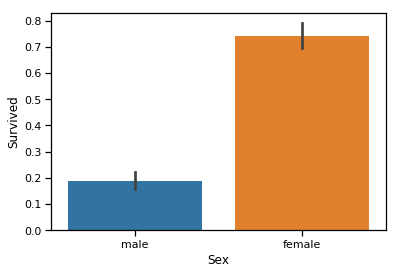

In [19]:
_ = sns.barplot(data = train, x = 'Sex', y = 'Survived')

Women have a significantly better survival rate than men! What about age? 

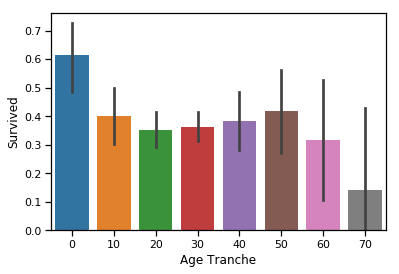

In [20]:
_ = sns.barplot(data = train, x = 'Age Tranche', y = 'Survived')

It seems kids and people in their fifties have survived better than others. The difference isn't as enormous as expected, though. What about the impact of the 'Siblings' column? 

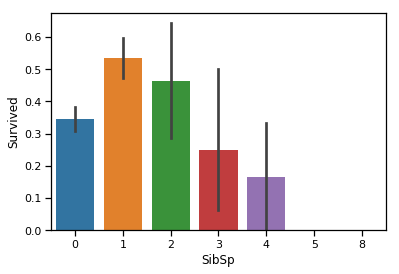

In [21]:
_ = sns.barplot(data = train, x = 'SibSp', y = 'Survived')

People with few to no siblings tend to have better survival rates than members of a very large family.


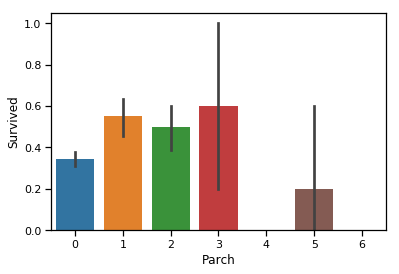

In [22]:
_ = sns.barplot(data = train, x = 'Parch', y = 'Survived')

Same pattern here : small families have better survival rates than very large ones, or than lonesome travelers.

Let's check the impact of the passenger's class:

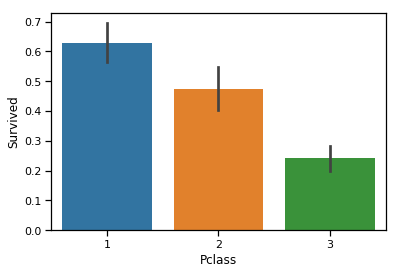

In [23]:
_ = sns.barplot(data = train, x = 'Pclass', y = 'Survived')

There is a clear positive correlation between the survival rate and the class in which the passenger travels. The economic background therefore appears to be relevant. Can we draw some information from the cabin number (whether or not it is referenced?)

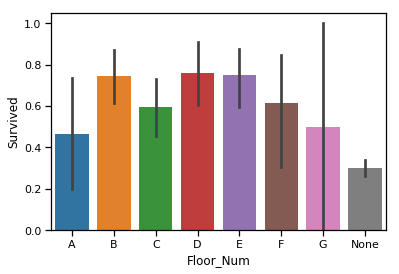

In [24]:
_ = sns.barplot(data = train, x = 'Floor_Num', y = 'Survived')

In general, a referenced cabin number indicates a higher probability of survival (there may be a link between the ticket class and the existence of a cabin number) 

Let's prepare our dataset for ML:

* First, let's categorize the family sizes and aggregate families with 4+ members

In [25]:
def fam_cat(n):
    if n>=4:
        return '4+'
    else:
        return str(n)
train['fam_cat'] = pd.DataFrame([train['SibSp'], train['Parch']]).max().apply(fam_cat).astype('category')

In [26]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Floor_Num', 'Title',
       'Age Tranche', 'fam_cat'],
      dtype='object')

In [27]:
travel_class = pd.get_dummies(train.Pclass, prefix = 'class',prefix_sep='_')
sex = pd.get_dummies(train.Sex, prefix = 'sex',prefix_sep='_')
age_cat = pd.get_dummies(train['Age Tranche'], prefix = 'agecat', prefix_sep='_')
fam_cat = pd.get_dummies(train['fam_cat'], prefix = 'famcat', prefix_sep='_')
floor_num = pd.get_dummies(train['Floor_Num'], prefix = 'floornum', prefix_sep='_')
embarkation = pd.get_dummies(train['Embarked'], prefix = 'embarkation', prefix_sep='_')

train_final = pd.concat([train[['PassengerId','Survived']], travel_class, sex, age_cat, fam_cat,floor_num, embarkation], axis = 1)

In [28]:
train_final

,PassengerId,Survived,class_1,class_2,class_3,sex_female,sex_male,agecat_0,agecat_10,agecat_20,...,floornum_B,floornum_C,floornum_D,floornum_E,floornum_F,floornum_G,floornum_None,embarkation_C,embarkation_Q,embarkation_S
0,1,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,2,1,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,3,1,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,4,1,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,5,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
887,888,1,1,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
888,889,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
889,890,1,1,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0


We are ready for machine learning! Let's import the relevant functions (we will use sklearn) to test different types of classifiers (before adding complexity to our models and performing hyperparameter tuning):

In [29]:
#splitting
from sklearn.model_selection import train_test_split

#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier


#hyperparameter tuning
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

In [30]:
X = train_final[list(train_final.columns)[2:]].values
y = train_final['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

In [31]:
models = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB(), SVC(), RandomForestClassifier(), BaggingClassifier(), AdaBoostClassifier(), GradientBoostingClassifier()]

accuracy_scores = []
f1_scores = []
roc_auc_scores = []

for m in models:
    m.fit(X_train, y_train)
    y_prediction = m.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_prediction))
    f1_scores.append(f1_score(y_test, y_prediction))
    roc_auc_scores.append(roc_auc_score(y_test, y_prediction))

models_names = ['Logistic Regression', 'Decision Tree Classifier', 'Gaussian Naive Bayes', 'SVC', 'Random Forest Classifier', 'Bagging Classifier', 'AdaBoost Classifier', 'Gradient Boosting Classifier']

models_performances = zip(accuracy_scores,f1_scores,roc_auc_scores)

models_names_and_perfs = dict(zip(models_names,models_performances))

models_names_and_perfs

{'Logistic Regression': (0.8475336322869955,
  0.8068181818181818,
  0.8434476319809882),
 'Decision Tree Classifier': (0.7982062780269058,
  0.7169811320754716,
  0.7730011882532677),
 'Gaussian Naive Bayes': (0.8116591928251121,
  0.7613636363636365,
  0.8055932778815142),
 'SVC': (0.8340807174887892, 0.7612903225806451, 0.80652690544899),
 'Random Forest Classifier': (0.820627802690583,
  0.7560975609756098,
  0.8020709556951282),
 'Bagging Classifier': (0.8161434977578476,
  0.7515151515151515,
  0.7984213206586318),
 'AdaBoost Classifier': (0.8430493273542601,
  0.8022598870056498,
  0.8397979969444916),
 'Gradient Boosting Classifier': (0.8430493273542601,
  0.7852760736196319,
  0.8246477677813614)}

Naive Bayes performs poorly, just like the bagging classifier. Support Vector Machine, as well as Random Forest and Gradient Boosting seem to perform well. How would a voting classifier including these three perform?

In [32]:
svc = SVC()
rfc = RandomForestClassifier()
gb = GradientBoostingClassifier()

vote = VotingClassifier(estimators = [('svc', svc),('rfc', rfc),('gb', gb)])

vote = vote.fit(X_train, y_train)
y_pred_vote = vote.predict(X_test)

vote_acc_score = accuracy_score(y_test, y_pred_vote)
vote_f1_score = f1_score(y_test, y_pred_vote)

vote_acc_score, vote_f1_score

(0.820627802690583, 0.75)

This is not bad but not mindblowing yet. Let's do some hyperparameter tuning for all of those models and come back to the voting classifier towards the end.

1. Hyperparameter Tuning for Random Forest

In [33]:
# params_rf = {'max_features': ['auto', 'sqrt'],
#              'min_samples_leaf': [1, 2, 4],
#              'min_samples_split': [2, 5, 10,15],
#              'n_estimators': [100,200,500]}

# rf = RandomForestClassifier(n_jobs = -1)

# clf = GridSearchCV(rf, params_rf)
# clf.fit(X_train, y_train)

# display(clf.best_params_)

# y_true, y_pred = y_test, clf.predict(X_test)
# print(classification_report(y_true, y_pred))

After a computationally expensive grid search, the best hyperparameters for our model are the following:

In [34]:
best_params = {'max_features': 'auto',
               'min_samples_leaf': 2,
               'min_samples_split': 5,
               'n_estimators': 200}

Let's re-run a random forest using those:

In [35]:
best_rfc = RandomForestClassifier(max_features = 'auto', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 200)
best_rfc.fit(X_train, y_train)
y_pred_best_rfc = best_rfc.predict(X_test)

best_rfc_acc_score = accuracy_score(y_test, y_pred_best_rfc)
best_rfc_f1_score = f1_score(y_test, y_pred_vote)

best_rfc_acc_score, best_rfc_f1_score

(0.8430493273542601, 0.75)

2. Hyperparameter tuning for Gradient Boosting

In [36]:
# params_gbc = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
#               'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

# gbc = GradientBoostingClassifier()

# clf = GridSearchCV(gbc, params_gbc)
# clf.fit(X_train, y_train)

# display(clf.best_params_)

# y_true, y_pred = y_test, clf.predict(X_test)
# print(classification_report(y_true, y_pred))

Best parameters for gradient boosting after grid search:

In [37]:
best_params = {'learning_rate': 0.01, 'n_estimators': 1000}

In [38]:
best_gbc = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 1000)
best_gbc.fit(X_train, y_train)
y_pred_best_gbc = best_gbc.predict(X_test)

best_gbc_acc_score = accuracy_score(y_test, y_pred_best_gbc)
best_gbc_f1_score = f1_score(y_test, y_pred_vote)

best_gbc_acc_score, best_gbc_f1_score

(0.8475336322869955, 0.75)

In [39]:
gbc_vote = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 1000)
rfc_vote = RandomForestClassifier(max_features = 'auto', min_samples_leaf = 2, min_samples_split = 5, n_estimators = 200)
svm_vote = SVC()

best_vote = VotingClassifier(estimators = [('svm', svm_vote),('rfc', rfc_vote),('gbc', gbc_vote)])

best_vote = best_vote.fit(X_train, y_train)
y_pred_best_vote = best_vote.predict(X_test)

best_vote_acc_score = accuracy_score(y_test, y_pred_best_vote)
best_vote_f1_score = f1_score(y_test, y_pred_best_vote)

best_vote_acc_score, best_vote_f1_score

(0.8340807174887892, 0.7672955974842768)

The best classifier is still therefore our gradient boosting classifier with hypertuned parameters. Let's try it on the test set.

In [40]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [41]:
test['Floor_Num'] = test['Cabin'].apply(lambda x: str(x)[0] if x != np.nan else np.nan)

m = []
for i in range(len(test['Floor_Num'])):
    if test.loc[i,'Floor_Num'] =='n' or test.loc[i,'Floor_Num'] =='T':
        test.loc[i,'Floor_Num'] = 'None'

test['Floor_Num'] = test['Floor_Num'].astype('category')

test['Title'] = test['Name'].apply(find_title)

for t in titles:
    m.append(test[test.Title == t].Age.mean())
mean_age_by_title = dict(zip(titles,m))

for i in range(len(test)):
    if test.loc[i,'Title'] is None:
        pass
    else:
        test.Age.fillna(mean_age_by_title[test.loc[i,'Title']], inplace = True)

def fam_cat(n):
    if n>=4:
        return '4+'
    else:
        return str(n)
    
test['Age Tranche'] = test['Age'].apply(cat_age).astype('category')
test['fam_cat'] = test['SibSp'].clip(lower = test['Parch']).apply(fam_cat).astype('category')

test_travel_class = pd.get_dummies(test.Pclass, prefix = 'class',prefix_sep='_')
test_sex = pd.get_dummies(test.Sex, prefix = 'sex',prefix_sep='_')
test_age_cat = pd.get_dummies(test['Age Tranche'], prefix = 'agecat', prefix_sep='_')
test_fam_cat = pd.get_dummies(test['fam_cat'], prefix = 'famcat', prefix_sep='_')
test_floor_num = pd.get_dummies(test['Floor_Num'], prefix = 'floornum', prefix_sep='_')
test_embarkation = pd.get_dummies(test['Embarked'], prefix = 'embarkation', prefix_sep='_')

test_final = pd.concat([test['PassengerId'], test_travel_class, test_sex, test_age_cat, test_fam_cat,test_floor_num, test_embarkation], axis = 1)

In [42]:
X = test_final[list(test_final.columns)[1:]].values

y_final_pred = best_gbc.predict(X)

output = pd.DataFrame(data = y_final_pred, index = test_final.PassengerId)

output.columns = ['Survived']

output.to_csv('Titanic_test_prediction.csv')